### Développement du Modèle de Détection et Classification d'Objets ###

## 1. Prétraitement des Données
Nous avons commencé par annoter les images du dataset contenant nos produits (Ramy). Chaque image est labellisée selon son type (canette, bouteille, pack, etc.).

## Collecte des images des produits concurrents
Pour enrichir notre dataset et permettre la segmentation concurrentielle, nous avons effectué du web scraping afin de collecter **automatiquement** des images de produits concurrents en utilisant le code source de la page web. Algorithme utilisé est join avec nos livrables et nous a permi de recuperer des photos des produits Rouiba ressemblante au style de données de Ramy (qu'on nous a fourni)


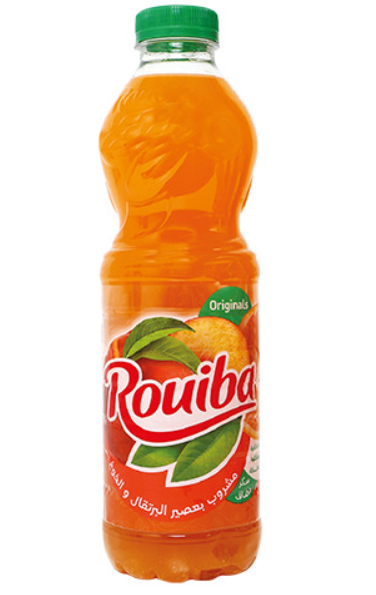  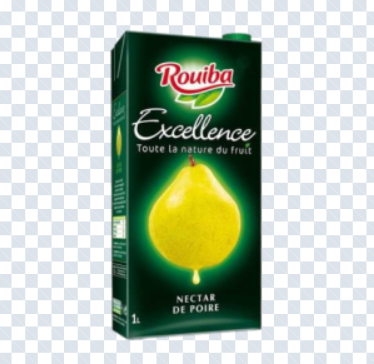

## 2. Détection des objets avec YOLO

Dans cette phase, notre but est de detecter les objects (produits) dans une image sans tenir compte de son type (bouteille, canette, ...) ni de l'entreprise qui le vend (Ramy, Rouiba, ...).
**Seulement un objet dans une image **

Le but sera de passer de cette image


image.png

A celle-ci:

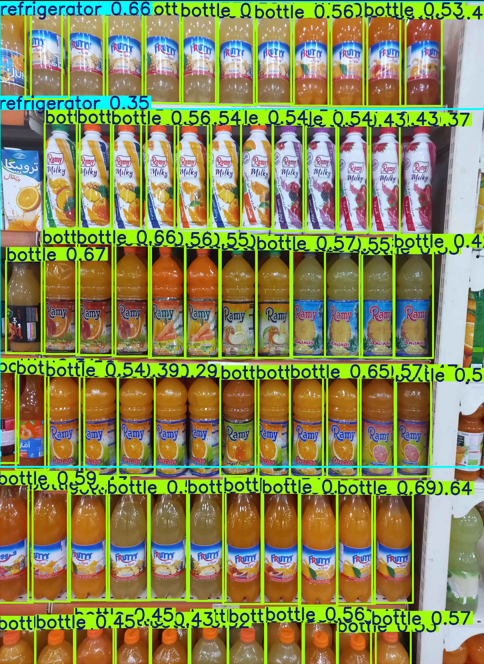

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
from ultralytics import YOLO
import cv2

# Charger le modele YOLOv8 pré-entraîné sur COCO (80 classes générales)
model = YOLO("yolov8n.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 51.0MB/s]


In [ ]:
# Charger l'image et faire la détection
image_path ="/content/image.jpg"
image = cv2.imread(image_path)

results = model(image_path)


image 1/1 /content/image.jpg: 480x640 35 bottles, 1 refrigerator, 3 vases, 310.1ms
Speed: 11.7ms preprocess, 310.1ms inference, 25.1ms postprocess per image at shape (1, 3, 480, 640)


In [ ]:
# Créer un dossier pour les crops des produits détectés
import os
from google.colab import drive

#Connection au drive
drive.mount('/content/drive')
output_dir = "/content/drive/MyDrive/AUP/detected_products"
os.makedirs(output_dir, exist_ok=True)

Mounted at /content/drive


In [ ]:
# Boucle sur chaque box détectée et sauvegarde des photos individuélles de chaque objet detecté dans le dossier detected_products
allowed_classes = [39, 41]  # Seules les classes bouteille et canette sont autorisées

filtered_boxes = []
for i, box in enumerate(results[0].boxes.xyxy):
    class_id = int(results[0].boxes.cls[i])
    if class_id in allowed_classes:
        x1, y1, x2, y2 = map(int, box)
        filtered_boxes.append((x1, y1, x2, y2, class_id))

In [ ]:
# Sauvegarder les résultats
cv2.imwrite("resultat.jpg", results[0].plot())

True

## 3. Classification des images avec ResNet18

Les objets extrait par YOLO dans la phase precedente seront passes ici au modele de classification ResNet18 , celui-ci entraine sur notre dataset prepare (des produits Ramy et des produits concurants resultants du web scrapping), permettera alors de classifier un objet doné dans l'une des classe connues (Canettes Ramy, Bouteilles Ramy, Bouteilles Rouiba, ...)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
from google.colab import drive
from PIL import Image

In [ ]:
#Connection au drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Transformer pour le prétraitement des images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset et DataLoader
train_dataset = datasets.ImageFolder(root="/content/drive/MyDrive/AUP/data/train", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = datasets.ImageFolder(root="/content/drive/MyDrive/AUP/data/validation", transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Charger un modèle pré-entraîné (ResNet18) sur notre data de training pour qu'ils apprennent a reconnaitre nos données
model = models.resnet18(weights=True)
num_ftrs = model.fc.in_features
target_classes = len(os.listdir("/content/drive/MyDrive/AUP/data/train"))
model.fc = nn.Linear(num_ftrs, target_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 58.0MB/s]


In [ ]:
# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Entraînement du modèle sur 20 epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Époque {epoch+1}/{num_epochs}, Perte: {running_loss/len(train_loader)}")

Époque 1/20, Perte: 0.8212948789199194
Époque 2/20, Perte: 0.4645472740133603
Époque 3/20, Perte: 0.37180060644944507
Époque 4/20, Perte: 0.376613770922025
Époque 5/20, Perte: 0.19756757840514183
Époque 6/20, Perte: 0.18754175305366516
Époque 7/20, Perte: 0.11414896479497354
Époque 8/20, Perte: 0.14363867416977882
Époque 9/20, Perte: 0.45761711212495965
Époque 10/20, Perte: 0.2535477889080842
Époque 11/20, Perte: 0.22425652698924145
Époque 12/20, Perte: 0.09402917015055816
Époque 13/20, Perte: 0.21422864900281033
Époque 14/20, Perte: 0.24945451971143484
Époque 15/20, Perte: 0.1073313985640804
Époque 16/20, Perte: 0.26789776266862947
Époque 17/20, Perte: 0.30650944480051595
Époque 18/20, Perte: 0.15324600413441658
Époque 19/20, Perte: 0.06726195973654588
Époque 20/20, Perte: 0.06389864084000389


**Évaluation avec des métriques standard** (accuracy, precision, recall, F1-score)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
# Évaluation du modèle
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calcul des métriques d'évaluation
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Validation Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

Validation Accuracy: 0.68
Precision: 0.81, Recall: 0.68, F1 Score: 0.67
Confusion Matrix:
[[8 0 0 0 0]
 [0 5 7 0 1]
 [1 0 8 0 0]
 [0 0 1 3 0]
 [0 0 3 0 3]]


le taux de precision de ce modele est de ce qui est assez bon comme resultat

In [ ]:
# Sauvegarde du modèle pour faciliter son utilisation dans les tests
torch.save(model.state_dict(), "resnet18_classification.pth")

**Test du modele** en donnant en entree une image de produit et visant savoir la classe a laquelle ce produit appartient

In [ ]:
# Charger le modèle entraîné avant de faire une prédiction
def load_model(model_path, model):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

# Fonction de prédiction sur une image
def predict_image(image_path, model, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        _, predicted = output.max(1)

    return class_names[predicted.item()]

In [ ]:
# Charger les classes
class_names = train_dataset.classes  # Liste des noms de classes
print(class_names)

# Charger le modèle avant de tester
model = load_model("resnet18_classification.pth", model)

['autre produit', 'bouteille_ramy', 'bouteille_rouiba', 'cannette_ramy', 'pack_ramy']


Test du modele sur cette image:

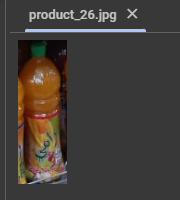

In [ ]:
#Image de test
test_image_path = "/content/drive/MyDrive/AUP/detected_products/product_26.jpg"
test_prediction = predict_image(test_image_path, model, class_names)
print(f"L'image est classée comme : {test_prediction}")

L'image est classée comme : bouteille_ramy
